# Postprocessing a DeepONet Trained for a Mass-Spring-Damper System 

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from tensorflow                           import keras

In [2]:
### Defining ODE and its Parameters

from scipy.integrate import solve_ivp

def fOrig(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

def fOrig_Source(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

Params = np.array([1.0, 0.5, 3.0], dtype=np.float64)

In [3]:
### Input Data

ROMNetFldr    = WORKSPACE_PATH + '/ROMNet/romnet/'
PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/DeepONet/Deterministic/Run_3/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/DeepONet/MCDropOut/Run_1/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/DeepONet/BayesByBackprop/Run_2/'

TrainingCases = [0]#[0,2,4,6,8]
TestCases     = [0,2,4]#[0,2]

NSamples      = 100

Nt            = 100
tout          = np.linspace(0.,15.,Nt)
SOLVER        = 'Radau'

LineTypeVec   = ['-',':','--','.-']*10

In [4]:
print("\n[ROMNet]: Reading Input File from: ", PathToRunFld)
sys.path.insert(0, PathToRunFld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData                 = inputdata(WORKSPACE_PATH, ROMNetFldr)

InputData.PathToRunFld    = PathToRunFld

InputData.PathToFigFld    = InputData.PathToRunFld+'/Figures/'
print("\n[ROMNet]: Final Figures can be Found here: " + InputData.PathToFigFld)

InputData.PathToParamsFld = InputData.PathToRunFld+'/Params/'
print("\n[ROMNet]: Final Parameters can be Found here: " + InputData.PathToParamsFld)

InputData.TBCheckpointFldr = None


[ROMNet]: Reading Input File from:  /Users/sventuri/WORKSPACE//ROMNet/MSD_10Cases/DeepONet/Deterministic/Run_3/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...

[ROMNet]: Final Figures can be Found here: /Users/sventuri/WORKSPACE//ROMNet/MSD_10Cases/DeepONet/Deterministic/Run_3//Figures/

[ROMNet]: Final Parameters can be Found here: /Users/sventuri/WORKSPACE//ROMNet/MSD_10Cases/DeepONet/Deterministic/Run_3//Params/


In [5]:
### Loading Surrogate

SurrogateType = InputData.SurrogateType
if (SurrogateType == 'FNN-SourceTerms'):
    SurrogateType = 'FNN'

sys.path.insert(0, InputData.ROMNetFldr  + '/src/Model/' + SurrogateType + '/' + InputData.ProbApproach + '/')
from Model import model

InputData.TrainIntFlg = 0

NN = model(InputData, InputData.PathToRunFld, None, None)

NN.load_params(InputData) 



# ModelFile      = InputData.PathToRunFld    + '/NNModel'
# Model          = keras.models.load_model(ModelFile, custom_objects={InputData.LossFunction: None})
# Model.summary()

# MCFile         = InputData.PathToParamsFld + "/ModelCheckpoint/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(MCFile)
# latest         = train.latest_checkpoint(checkpoint_dir)
# Model.load_weights(latest)

[ROMNet]:   Defining ML Model from Scratch
InputData.BranchVars= ['x', 'v']
[ROMNet]:   Compiling ML Model with Loss and Optimizer
[ROMNet]:   Summarizing ML Model Structure:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
tf.split (TFOpLambda)           [(None, 2), (None, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 2)            5           tf.split[0][0]                   
__________________________________________________________________________________________________
normalization_1 (N

In [6]:
LName   = 'Trunk_1_HL' + str(len(InputData.TrunkActFun[0]))

Trunk = keras.Model(NN.Model.inputs, NN.Model.get_layer(LName).output)
Trunk.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
tf.split (TFOpLambda)        [(None, 2), (None, 1)]    0         
_________________________________________________________________
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
Trunk_1_HL1 (Dense)          (None, 32)                64        
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Trunk_1_HL2 (Dense)          (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0   

In [7]:
# LName   = 'Branch_'+InputData.BranchVars[0]+'_HL' + str(len(InputData.TrunkActFun[0]))
# '_HL' + str(len(InputData.BranchActFun[0]))

# Branch1 = keras.Model(NN.Model.inputs, NN.Model.get_layer(LName).output)
# Branch1.summary()

In [8]:
# LName   = 'Branch_'+InputData.BranchVars[1]+'_HL' + str(len(InputData.BranchActFun[1]))

# Branch2 = keras.Model(NN.Model.inputs, NN.Model.get_layer(LName).output)
# Branch2.summary()

iVar =  1
u0 =  [-1.31420311 -0.94960164]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


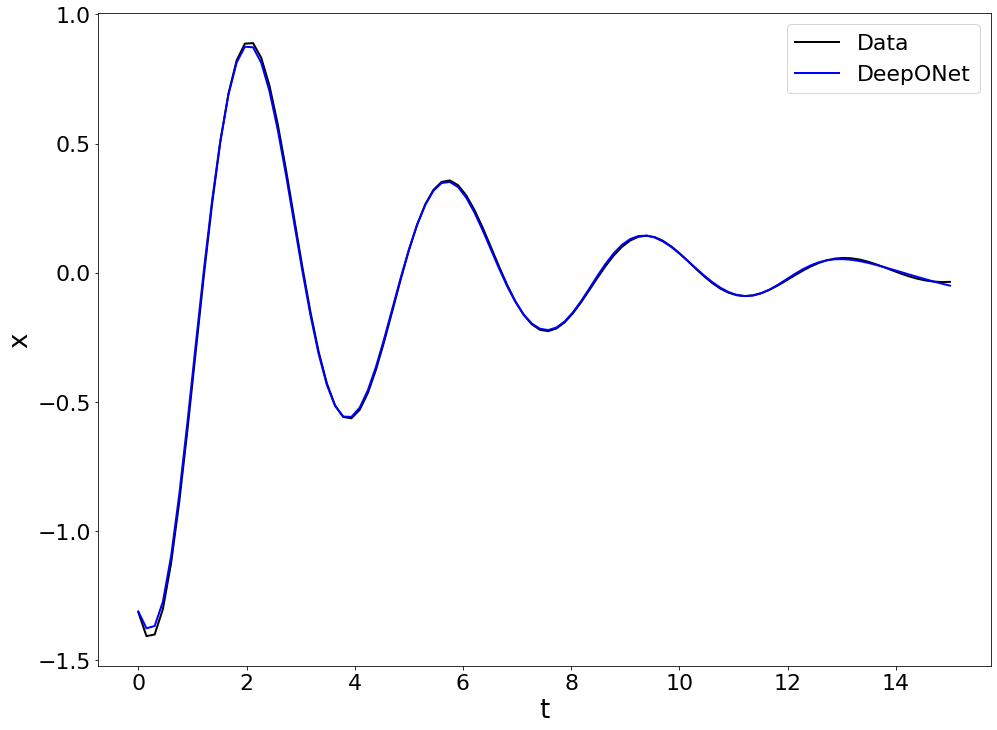

In [9]:
### Evaluating on Training Data

FileName  = InputData.PathToTrainDataFld + '/' + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Input     = Data[InputData.BranchVars].to_numpy()
VarNames  = list(Data.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T


## Variable to Be Visualized
VarOI     = 'x'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break

        
for iTraining in TrainingCases:

    print('u0 = ', u[iTraining,:])

    ### Generating Data  
    output     = solve_ivp( fOrig, tout[[0,-1]], u[iTraining,:], method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    tOrig      = tout
    yMatOrig   = output.y.T
    
    ### Creating NN Input
    tPred     = tOrig[...,np.newaxis]
    Nt        = len(tPred)
    uPred     = u[iTraining,:]*np.ones((Nt,2))
    InputPred = np.concatenate((uPred,tPred), axis=1)
    
    if (InputData.ProbApproach == 'Deterministic') or (NSamples == 1):
    
        yMat       = NN.predict(InputPred)    
        yTrunk     = Trunk.predict(InputPred)
        
        ## Plotting
        fig = plt.figure(figsize=(16, 12))
        plt.plot(tOrig, yMatOrig[:,iVar-1],  'k-', label='Data')
        plt.plot(tPred, yMat[:,iVar-1],      'b-', label='DeepONet')
        plt.xlabel('t')
        plt.ylabel(VarOI)
        plt.legend()
        plt.show()
        
    else:
        
        ### Sampling NN
        yMat_sum   = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))
        yMat_sqr   = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))
        yTrunk_sum = np.zeros((yMatOrig.shape[0], 32))
        yTrunk_sqr = np.zeros((yMatOrig.shape[0], 32))

        for iSample in range(NSamples):
            yMat      = NN.predict(InputPred)    
            yMat_sum += yMat
            yMat_sqr += yMat**2

            yTrunk      = Trunk.predict(InputPred)
            yTrunk_sum += yTrunk
            yTrunk_sqr += yTrunk**2

        yTrunk_mean = yTrunk_sum/NSamples
        yTrunk_std  = np.sqrt( yTrunk_sqr/NSamples - yTrunk_mean**2 )
        yTrunk_p1   = yTrunk_mean + 1.*yTrunk_std
        yTrunk_m1   = yTrunk_mean - 1.*yTrunk_std
        yTrunk_p2   = yTrunk_mean + 2.*yTrunk_std
        yTrunk_m2   = yTrunk_mean - 2.*yTrunk_std
        yTrunk_p3   = yTrunk_mean + 3.*yTrunk_std
        yTrunk_m3   = yTrunk_mean - 3.*yTrunk_std


        yMat_mean = yMat_sum/NSamples
        yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
        yMat_p1   = yMat_mean + 1.*yMat_std
        yMat_m1   = yMat_mean - 1.*yMat_std
        yMat_p2   = yMat_mean + 2.*yMat_std
        yMat_m2   = yMat_mean - 2.*yMat_std
        yMat_p3   = yMat_mean + 3.*yMat_std
        yMat_m3   = yMat_mean - 3.*yMat_std


        ## Plotting
        fig = plt.figure(figsize=(16, 12))
        plt.plot(tOrig, yMatOrig[:,iVar-1],  'k-', label='Data')
        plt.plot(tPred, yMat_mean[:,iVar-1], 'b-', label=r'DeepONet, $\mu$')
        plt.plot(tPred, yMat_p3[:,iVar-1],   'b:', label=r'DeepONet, $\mu+3\sigma$')
        plt.plot(tPred, yMat_m3[:,iVar-1],   'b:', label=r'DeepONet, $\mu-3\sigma$')
        plt.xlabel('t')
        plt.ylabel(VarOI)
        plt.legend()
        plt.show()

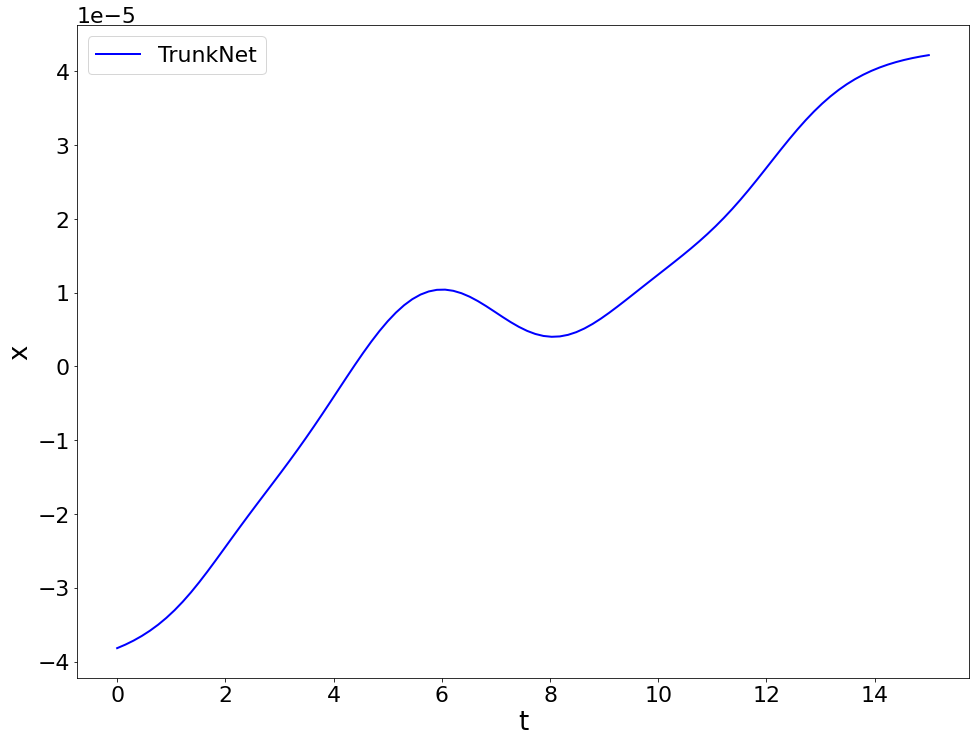

In [10]:
### Evaluating Trunk's Last Layer on Training Data

## Neuron of Interest for Trunk's Last Layer
iN  = 4

if (InputData.ProbApproach == 'Deterministic') or (NSamples == 1):
    
    fig = plt.figure(figsize=(16, 12))
    plt.plot(tPred, yTrunk[:,iN], 'b-', label=r'TrunkNet')
    plt.xlabel('t')
    plt.ylabel(VarOI)
    plt.legend()
    plt.show()
    
else:
    
    fig = plt.figure(figsize=(16, 12))
    plt.plot(tPred, yTrunk_mean[:,iN], 'b-', label=r'TrunkNet, $\mu$')
    plt.plot(tPred, yTrunk_p3[:,iN],   'b:', label=r'TrunkNet, $\mu+3\sigma$')
    plt.plot(tPred, yTrunk_m3[:,iN],   'b:', label=r'TrunkNet, $\mu-3\sigma$')
    plt.xlabel('t')
    plt.ylabel(VarOI)
    plt.legend()
    plt.show()

iVar =  1
u0 =  [-1.07856426 -0.82275602]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


u0 =  [-0.44206703 -0.41951141]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


u0 =  [ 0.51190231 -0.21291579]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


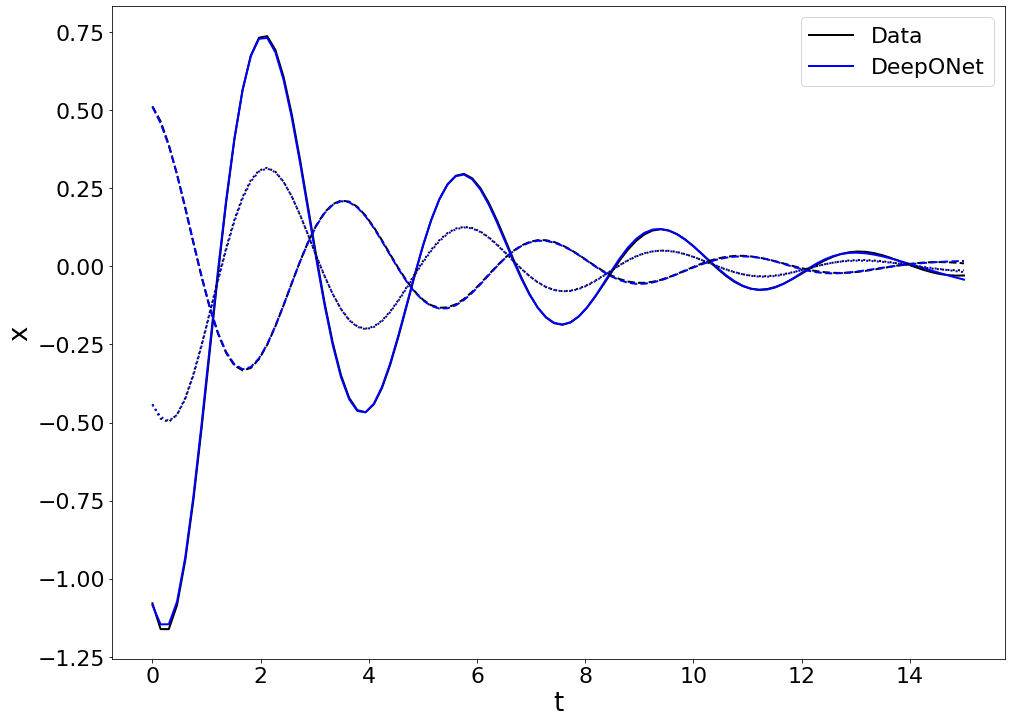

In [11]:
### Evaluating on Test Data

FileName  = InputData.PathToTestDataFld + '/' + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Input     = Data[InputData.BranchVars].to_numpy()
VarNames  = list(Data.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T


## Variable to Be Visualized
VarOI     = 'x'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break

iSim = 0
for iTest in TestCases:
    
    print('u0 = ', u[iTest,:])

    ### Generating Data  
    output     = solve_ivp( fOrig, tout[[0,-1]], u[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    tOrig      = tout
    yMatOrig   = output.y.T
    
    ### Creating NN Input
    tPred     = tOrig[...,np.newaxis]
    Nt        = len(tPred)
    uPred     = u[iTest,:]*np.ones((Nt,2))
    InputPred = np.concatenate((uPred,tPred), axis=1)
    
    if (InputData.ProbApproach == 'Deterministic') or (NSamples == 1):
        
        yMat = NN.predict(InputPred)    
        
        ## Plotting
        
        if (iSim == 0):
            fig    = plt.figure(figsize=(16, 12))
            Label1 = 'Data'
            Label2 = 'DeepONet'
        else:
            Label1 = None
            Label2 = None
    
        plt.plot(tOrig, yMatOrig[:,iVar-1],  'k'+LineTypeVec[iSim], label=Label1)
        plt.plot(tPred, yMat[:,iVar-1],      'b'+LineTypeVec[iSim], label=Label2)
        plt.xlabel('t')
        plt.ylabel(VarOI)
        plt.legend()
        #plt.show()
        
    else:

        ### Sampling NN
        yMat_sum = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))
        yMat_sqr = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))

        for iSample in range(NSamples):
            yMat_ = NN.predict(InputPred)    
            yMat_sum += yMat_
            yMat_sqr += yMat_**2

        yMat_mean = yMat_sum/NSamples
        yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
        yMat_p1   = yMat_mean + 1.*yMat_std
        yMat_m1   = yMat_mean - 1.*yMat_std
        yMat_p2   = yMat_mean + 2.*yMat_std
        yMat_m2   = yMat_mean - 2.*yMat_std
        yMat_p3   = yMat_mean + 3.*yMat_std
        yMat_m3   = yMat_mean - 3.*yMat_std


        ## Plotting
        fig = plt.figure(figsize=(16, 12))
        plt.plot(tOrig, yMatOrig[:,iVar-1],  'k-', label='Data')
        plt.plot(tPred, yMat_mean[:,iVar-1], 'b-', label=r'DeepONet, $\mu$')
        plt.plot(tPred, yMat_p3[:,iVar-1],   'b:', label=r'DeepONet, $\mu+3\sigma$')
        plt.plot(tPred, yMat_m3[:,iVar-1],   'b:', label=r'DeepONet, $\mu-3\sigma$')
        plt.xlabel('t')
        plt.ylabel(VarOI)
        plt.legend()
        plt.show()
        
    iSim += 1